<h1 style="text-align: center">TF4062: Introduction to finite element method</h1>
<h2 style="text-align: center">Iwan Prasetyo and Fadjar Fathurrahman</h2>




-------------------

In this notebook we will do some explorations in symbolic implementation of finite element method in 1d using linear shape functions

We will mainly using SymPy module, so we import all symbols from this module.

In [1]:
from sympy import *

We will activate LaTeX for displaying SymPy outputs.

In [2]:
init_printing(use_latex=True)

Plotting stuffs. SymPy also can do it, however we would like to use NumPy + Matplotlib for plotting.

In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt

In [5]:
import IPython.display
IPython.display.set_matplotlib_formats("svg")

Don't use this if you want to use the default style.

In [6]:
import matplotlib
matplotlib.style.use("dark_background")

-----------------

# Model differential equation

As a model problem, we will consider determining the conduction of heat
on a slender homogeneous metal wire of length L with a constant cross
section. Assume that the left end is exposed to a prescribed heat flux, $q$,
the right end is held at a constant temperature, $T = T_L$, and the length of
the rod is surrounded by insulating material.

The differential equation that governs the distribution of temperature across the rod can be written as
\begin{equation}
-k \frac{\mathrm{d}^2 T}{\mathrm{d}x^2} = Q
\end{equation}
for $0 < x < L$, where $k$ is the thermal conductivity of the material
which is assumed constant and $Q$ is the internal heat source.
The boundary conditions for this problem are (Neumann BC, natural BC)
\begin{equation}
-k\frac{\mathrm{d}T}{\mathrm{d}x} = q \quad \text{at } x = 0
\end{equation}
and (Dirichlet BC, essential BC)
\begin{equation}
T = T_{L} \quad \text{at } x = L
\end{equation}

The analytical solution to this problem can be expressed as:
\begin{equation}
T(x) = T_{L} + \frac{q}{k}(L - x) + \frac{1}{k} \int_{x}^{L}
\left( \int_{0}^{y} Q(z)\,\mathrm{d}z \right)\,\mathrm{d}y
\end{equation}

For constant $Q$, this equation reduces to
\begin{equation}
T(x) = T_{L} + \frac{q}{k}(L - x) + \frac{Q}{2k}(L^2 - x^2)
\end{equation}

# Discretization

First we need to define grid points or mesh. For simplicity let's use two elements, or three nodal points (nodes).

Suppose that we will define our nodes or grid points within interval $[0,L]$.
For generality, we will describe $L$ as a symbolic object. We will also introduce $x$ as our symbolic variable for spatial variable.

In [7]:
L = Symbol("L", real=True, positive=True)
x = Symbol("x", real=True)

Here, we initialize our nodes and spacings. The nodes are in variable `xnodes` which is a list containing symbolic objects.

In [8]:
Nelements = 2
Npoints = Nelements + 1

xnodes = [Integer(0), L/2, L] # I use Integer(0) to make sure that all xnodes are SymPy objects
h = [xnodes[i+1]-xnodes[i] for i in range(Npoints-1)]

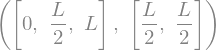

In [9]:
xnodes, h

# Linear shape functions

For general case of linear elements we have the following shape functions or basis functions. For left
boundary points:
$$
N_{1}(x) = \begin{cases}
\dfrac{x_{2} - x}{h_1} & x_{1} \leq x \leq x_{2} \\[10pt]
0                     & \text{otherwise}
\end{cases}
$$

For interior points:

$$
N_{i}(x) = \begin{cases}
\dfrac{x - x_{i-1}}{h_{i-1}} & x_{i-1} \leq x \leq x_{i} \\[10pt]
\dfrac{x_{i+1} - x}{h_{i}} & x_{i} \leq x \leq x_{i+1},\quad i=2,3,\ldots,n \\[10pt]
0                     & \text{otherwise}
\end{cases}
$$

And for right boundary points:
$$
N_{n+1}(x) = \begin{cases}
\dfrac{x - x_{n}}{h_{n}} & x_{n} \leq x \leq x_{n+1} \\[10pt]
0                     & \text{otherwise}
\end{cases}
$$

where $h_{i}$ are the spacings between nodal points.
$$
h_{i} = x_{i+1} - x_{i}
$$

Now we will begin defining our shape functions. Each shape function is defined as a piecewise function. In SymPy, we can define a piecewise function by using `Piecewise` class of SymPy.

In [11]:
cond1 = (x >= xnodes[0]) & (x <= xnodes[1])
f1 = (xnodes[1] - x)/h[0]
N_first = Piecewise( (f1, cond1), (0, True) )

The Piecewise object is need tuples of boolean and expression. For the first shape function, there are two conditions. We only specify one and the "otherwise" case is defined as `(0,True)`.

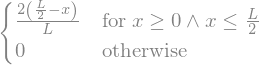

In [12]:
N_first

Here we define the second shape function. It needs three conditions, two conditions are defined with boolean expressions and the "otherwise" case as `(0,True)`.

In [13]:
cond1 = (x >= xnodes[0]) & (x <= xnodes[1])
f1 = ( x - xnodes[0])/h[0]
#
cond2 = (x >= xnodes[1]) & (x <= xnodes[2])
f2 = (xnodes[2] - x)/h[1]
#
N_second = Piecewise( (f1, cond1), (f2, cond2), (0, True) )

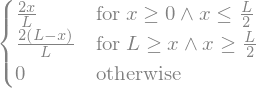

In [14]:
N_second

Now, we should be able to define the third (or last shape function) as follow. Note that I have used the variable `Npoints` instead of literal 3.

In [15]:
cond1 = (x >= xnodes[Npoints-2]) & (x <= xnodes[Npoints-1])
f1 = (x - xnodes[Npoints-2])/h[Npoints-2]
N_third = Piecewise( (f1, cond1), (0, True) )

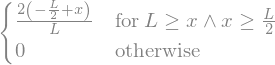

In [16]:
N_third

Now that we have defined the shape functions we wish to be able do something with them.

The first thing that we will try is to plot them. As our shape functions contains parameter $L$ and $x$ we should give them numerical values in order to be able to visualize them. This can be done by using the method `subs`. This method need a dictionary of symbol and the numerical value that we wish to substitute in the corresponding symbol.

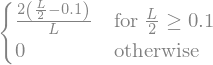

In [17]:
N_first.subs({x: 0.1})

In [18]:
N_first.subs({x: 0.1, L: 1.0})

In [21]:
N_first.subs({x: L/2})

In [27]:
N_first.subs({x: 0.0})

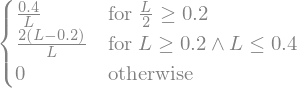

In [23]:
N_second.subs({x: 0.2})

In [24]:
Lnum = 1.0

In [25]:
num_dicts = {x: 1.0, L: Lnum}

In [26]:
N_third.subs(num_dicts)

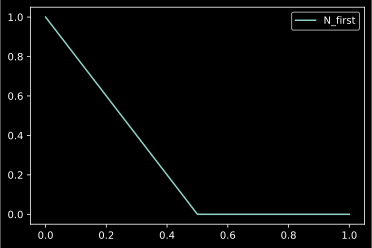

In [28]:
Lnum = 1.0
NptsPlot = 101
xplt = np.linspace(0.0, Lnum, NptsPlot)
yplt = np.zeros(NptsPlot)
plt.clf()
for ip in range(NptsPlot):
    yplt[ip] = N_first.subs( {x: xplt[ip], L: Lnum } )
plt.plot(xplt, yplt, label="N_first")
plt.legend();

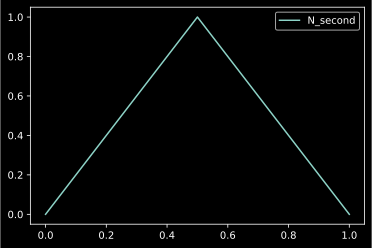

In [29]:
Lnum = 1.0
NptsPlot = 101
xplt = np.linspace(0.0, Lnum, NptsPlot)
yplt = np.zeros(NptsPlot)
plt.clf()
for ip in range(NptsPlot):
    yplt[ip] = N_second.subs( {x: xplt[ip], L: Lnum } )
plt.plot(xplt, yplt, label="N_second")
plt.legend();

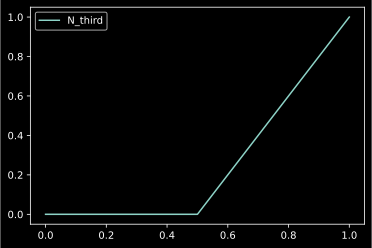

In [30]:
Lnum = 1.0
NptsPlot = 101
xplt = np.linspace(0.0, Lnum, NptsPlot)
yplt = np.zeros(NptsPlot)
plt.clf()
for ip in range(NptsPlot):
    yplt[ip] = N_third.subs( {x: xplt[ip], L: Lnum } )
plt.plot(xplt, yplt, label="N_third")
plt.legend();

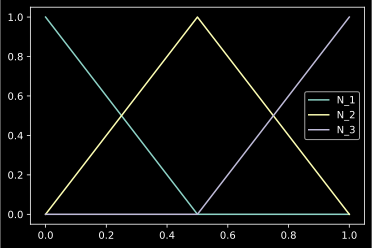

In [31]:
Lnum = 1.0
NptsPlot = 101
xplt = np.linspace(0.0, Lnum, NptsPlot)
yplt_1 = np.zeros(NptsPlot)
yplt_2 = np.zeros(NptsPlot)
yplt_3 = np.zeros(NptsPlot)
plt.clf()
for ip in range(NptsPlot):
    yplt_1[ip] = N_first.subs( {x: xplt[ip], L: Lnum } )
    yplt_2[ip] = N_second.subs( {x: xplt[ip], L: Lnum } )
    yplt_3[ip] = N_third.subs( {x: xplt[ip], L: Lnum } )
plt.plot(xplt, yplt_1, label="N_1")
plt.plot(xplt, yplt_2, label="N_2")
plt.plot(xplt, yplt_3, label="N_3")
plt.legend();

## Integrals and derivatives

In the finite element methods, we need to be able to do calculate derivatives and integrals of our basis functions such as:

$$
\int_{0}^{L} N_{1}(x) N_{2}(x)\,\mathrm{d}x
$$

and 

$$
\int_{0}^{L} \frac{\mathrm{d} N_{1}(x)}{\mathrm{d}x} \frac{\mathrm{d} N_{2}(x)}{\mathrm{d}x} \,\mathrm{d}x
$$

The class `Integral` can be used to construct an evaluated integral (it is useful to displaying purpose). For example:

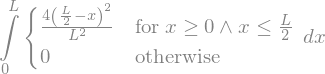

In [32]:
I1 = Integral(N_first*N_first, (x,0,L))
I1

To actually carry out the calculation we can call the method `doit()`.

In [33]:
I1.doit()

Alternatively, the function `integrate` can be used to calculate the integrals directly.

In [40]:
integrate(N_first*N_second, (x,0,L))

In [41]:
integrate(N_first*N_first, (x,0,L))

In [42]:
integrate(N_first*N_first, (x,0,L/2))

In [43]:
integrate(N_first*N_third, (x,0,L))

To calculate a derivative, we can use `Derivative` (for unevaluated derivative) or `diff` (directly evaluate the derivative):

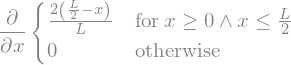

In [44]:
Derivative(N_first, x)

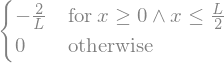

In [45]:
Derivative(N_first, x).doit()

In [46]:
expr1 = Derivative(N_first, x, 2).doit()

In [47]:
expr1

In [ ]:
diff(N_first, x)

$C^{0}$ functions.

$C^{1}$ functions.

$C^{\infty}$ functions.

Now let's try the following integral:
$$
\int_{0}^{L} N_{1}(x)\,\frac{\mathrm{d}N_{1}(x)}{\mathrm{d}x}\,\mathrm{d}x
$$

In [49]:
integrate(N_first * diff(N_first,x), (x,0,L))

## Weak form

We assume that we have derived the weak form for our differential equation. For example:

$$
\int_{0}^{L} k
\left(
\frac{\mathrm{d} w(x)}{\mathrm{d}x}
\frac{\mathrm{d}T(x)}{\mathrm{d}x} \right)\, \mathrm{d}x -
\int_{0}^{L} w(x)\,Q\, \mathrm{d}x -
\left[ k\, w(x) \frac{\mathrm{d}T(x)}{\mathrm{d}x} \right]_{0}^{L} = 0
$$

We now wish to derive system of linear equations in terms of unknown nodal values of $T(x)$.

Now we will introduce some several symbolic objects:

In [50]:
T = Function("T")(x)
w = Function("w")(x)
k = Symbol("k", real=True, positive=True)
Q = Symbol("Q", real=True)

We also introduce the expansion that we will use to approximate $T(x)$:
$$
T(x) = \sum_{j=1}^{n+1} T_{j} N_{j}(x) 
$$
or for our particular case, i.e. $n=2$:
$$
T(x) = T_{1} N_{1}(x) + T_{2} N_{2}(x) + T_{3} N_{3}(x)
$$

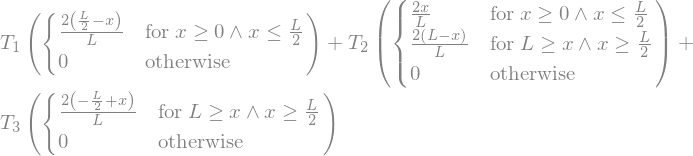

In [51]:
T_1 = Symbol("T_1", real=True)
T_2 = Symbol("T_2", real=True)
T_3 = Symbol("T_3", real=True)
T_expansion = T_1*N_first + T_2*N_second + T_3*N_third
T_expansion

In [52]:
T_expansion.subs({x: 0.1, L: Lnum})

In [53]:
T_expansion.subs({x: 0.6, L: Lnum})

In [54]:
T_expansion.subs({x: 1.0, L: Lnum})

# Derivation of linear systems

Now, we are ready to derive the equation for $w(x) = N_{1}(x)$, etc. To make things a bit easier, we will divide the terms arising from the weak form into three types:

- the stiffness term (will be referred by variable `term1`),
- source term (will be referred by variable `term2`), and
- boundary term (will be referred by variable `term3`).

## Stiffness term or diffusion term

The first term is:
$$
\int_{0}^{L} k
\left(
\frac{\mathrm{d} w(x)}{\mathrm{d}x}
\frac{\mathrm{d}T(x)}{\mathrm{d}x} \right)\, \mathrm{d}x
$$

Let's start with the integrand:

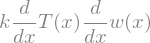

In [55]:
expr1 = k * Derivative(w,x) * Derivative(T, x)
expr1

We do the following substitution:
- $T(x) \leftarrow \sum_{j=1}^{3} T_{j} N_{j}(x)$, and
- $w(x) \leftarrow N_{1}(x)$:

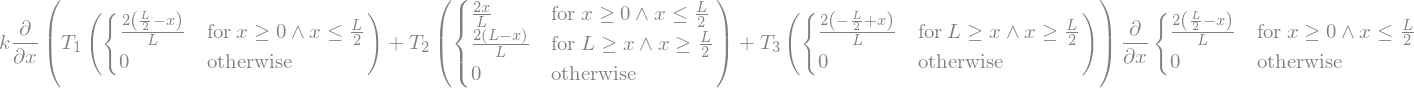

In [56]:
expr1s = expr1.subs({T: T_expansion, w: N_first})
expr1s

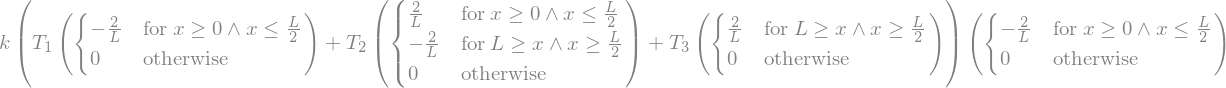

In [57]:
expr1ss = expr1s.doit()
expr1ss

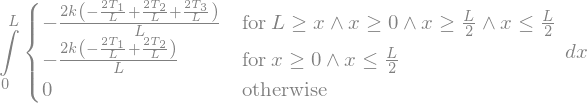

In [58]:
I1 = Integral(expr1ss, (x,0,L))
I1

Finally, do the integration:

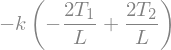

In [59]:
term1_first = I1.doit()
term1_first

## Source term

The source term is:
$$
\int_{0}^{L} w(x)\,Q\, \mathrm{d}x
$$

In [60]:
expr2 = Integral( Q*w, (x,0,L) )
term2_first = expr2.subs({w: N_first}).doit()
term2_first

## Boundary terms

$$
\left[ k\, w(x) \frac{\mathrm{d}T(x)}{\mathrm{d}x} \right]_{0}^{L}
$$

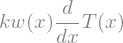

In [61]:
expr3 = k*w*Derivative(T,x)
expr3

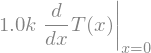

In [62]:
term3_x0 = expr3.subs({ w: N_first, x: 0, L: Lnum})
term3_x0

In [63]:
term3_xL = expr3.subs({ w: N_first, x: Lnum, L: Lnum})
term3_xL

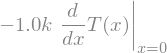

In [64]:
term3_first = term3_xL - term3_x0
term3_first

## Overall contributions for the first weight function

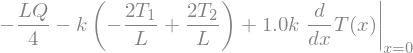

In [71]:
eq_first = term1_first - term2_first - term3_first
eq_first

In [66]:
q0 = Symbol("q_0", real=True)

Let's do the substitution (from the boundary condition):
$$
-k \frac{\mathrm{d}T(x)}{\mathrm{d}x} \leftarrow q_{0}
$$
or
$$
k \frac{\mathrm{d}T(x)}{\mathrm{d}x} \leftarrow -q_{0}
$$

The term we want to substitute is

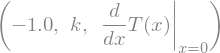

In [67]:
term3_first.args

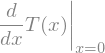

In [68]:
term3_first.args[2]

Here, we do the substitution:

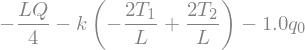

In [72]:
eq_first = eq_first.subs( {k*term3_first.args[2]: -q0} )
eq_first

## From the second weight function

Now, we repeat the above procedure for the second weight function (or the second shape function, for Galerkin FEM)

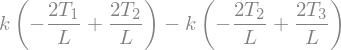

In [73]:
expr1s = expr1.subs({T: T_expansion, w: N_second})
expr1ss = expr1s.doit()
term1_second = Integral(expr1ss, (x,0,L)).doit()
term1_second

In [74]:
term2_second = expr2.subs({w: N_second}).doit()
term2_second

In [75]:
term3_x0 = expr3.subs({ w: N_second, x: 0, L: Lnum})
term3_xL = expr3.subs({ w: N_second, x: Lnum, L: Lnum})
term3_second = term3_xL - term3_x0
term3_second

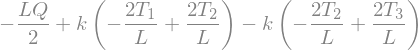

In [76]:
eq_second = term1_second - term2_second - term3_second
eq_second

## Equation for third weight function

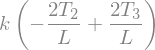

In [77]:
expr1s = expr1.subs({T: T_expansion, w: N_third})
expr1ss = expr1s.doit()
term1_third = Integral(expr1ss, (x,0,L)).doit()
term1_third

In [79]:
term2_third = expr2.subs({w: N_third}).doit()
term2_third

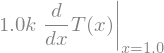

In [80]:
term3_x0 = expr3.subs({ w: N_third, x: 0, L: Lnum})
term3_xL = expr3.subs({ w: N_third, x: Lnum, L: Lnum})
term3_third = term3_xL - term3_x0
term3_third

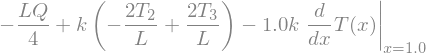

In [81]:
eq_third = term1_third - term2_third - term3_third
eq_third

In [82]:
qL = Symbol("q_L", real=True)

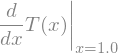

In [83]:
term3_xL.args[2]

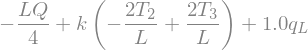

In [84]:
eq_third = eq_third.subs( {k*term3_xL.args[2]: -qL} )
eq_third

# System of linear equations

Prepare for the numerical values:

In [85]:
T_L = 10.0
Lnum = 1.0
knum = 4.0
Qnum = 1.0
q0num = 10.0
num_dict = { L: Lnum, k: knum, Q: Qnum, q0: q0num, T_3: T_L}

Here, we only solve for $T_1$ and $T_2$ (as we already know the value of $T_3$ from the boundary condition):

In [86]:
linear_system = [eq_first.subs(num_dict), eq_second.subs(num_dict)]
linear_system

In [87]:
sols_T = linsolve(linear_system, T_1, T_2)
sols_T

The function `linsolve` returns a set of values.

In [88]:
len(sols_T.args[0]), type(sols_T.args[0])

(2, sympy.core.containers.Tuple)

In [89]:
sols_T.args[0][0], sols_T.args[0][1]

The first value is for $T_1$ and the second one is for $T_2$. Please compare this numerical values with the analytical solution.

The third equation can used to calculate the flux at the $x=L$ boundary.

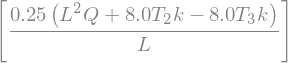

In [90]:
sols_qL = solve(eq_third, qL)
sols_qL

In [91]:
type(sols_qL)

list

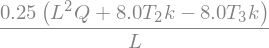

In [93]:
sols_qL[0]

The function `solve` returns a list of SymPy expression. We only have one possible expression for $q_L$.

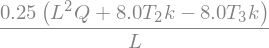

In [94]:
sols_qL[0]

Now, we substitute the into `sols_qL` the numerical values defined in `num_dict` and also the solution for $T_2$ that we have obtained before.

In [95]:
sols_qL[0].subs(num_dict).subs({T_2: sols_T.args[0][1]})

You may also verify this from the analytic solution.

# Assignments

- Wrap these procedures into (several functions) such that we can work with arbitrary number of elements. We will not try it to a large number of elements (> 100, for example), because symbolic computations are not suitable for that. For large number of elements, we should use fully numerical approach. You resulting functions should be able to accomodate grid points with nonuniform spacing. It also should have a separate function to do plotting stuffs.

- Modify your program such that it can accomodate spatially-varying (non-constant) source term and conduction coefficient, i.e. $Q(x)$ instead of $Q$ and $k(x)$ instead of $k$. 

- Repeat the procedure with quadratic and cubic shape functions.